In [2]:
# multivariate multi-step encoder-decoder lstm
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
import tensorflow as tf
import pandas as pd
import scipy.stats

from tensorflow.keras.models import load_model
from tensorflow.keras.models import clone_model
from numpy import average

from math import sqrt
from numpy import concatenate
import numpy as np
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
# from sklearn.metrics import mean_squared_error
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.layers import LSTM
import matplotlib.pyplot as plt


# Dataset 3L bioreactor

### Here RUN1: RBD_CD4L, RUN2: hSPB and RUN3: RBD

<class 'pandas.core.frame.DataFrame'>
Index: 5783 entries, 2020-09-30 13:04 to 2020-10-04 13:21
Data columns (total 53 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   viability                            5768 non-null   float64
 1   total_cell_density_c_ml              5768 non-null   float64
 2   viable_cell_density_c_ml             5768 non-null   float64
 3   aav6_titer_vg_ml                     1640 non-null   float64
 4   file_name                            5783 non-null   object 
 5   workbook_name                        5783 non-null   object 
 6   qo2_sparged_ml_min                   5783 non-null   float64
 7   cumo2_ml                             5783 non-null   float64
 8   q_co2_overlay_ml_min                 5783 non-null   float64
 9   q_air_overlay_ml_min                 5783 non-null   float64
 10  q_tot_overlay                        5783 non-null   float64
 11  yco2_ove

/usr/local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
/usr/local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
/usr/local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
/usr/local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
/usr/local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
/usr/local/lib/python3.8/site-packages/pandas/plot

(array([-1000.,     0.,  1000.,  2000.,  3000.,  4000.,  5000.,  6000.,
         7000.]),
 [Text(-1000.0, 0, '2020-10-11 23:23'),
  Text(0.0, 0, '2020-10-08 14:25'),
  Text(1000.0, 0, '2020-10-09 7:06'),
  Text(2000.0, 0, '2020-10-09 23:45'),
  Text(3000.0, 0, '2020-10-10 16:25'),
  Text(4000.0, 0, '2020-10-11 9:04'),
  Text(5000.0, 0, '2020-10-12 1:43'),
  Text(6000.0, 0, ''),
  Text(7000.0, 0, '')])

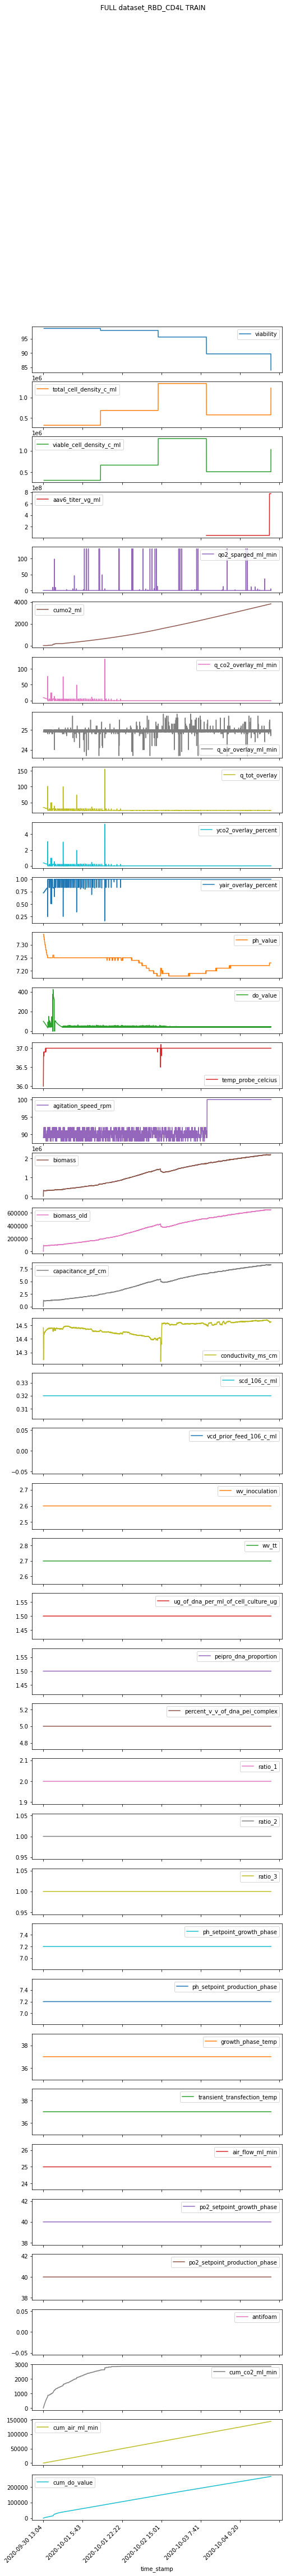

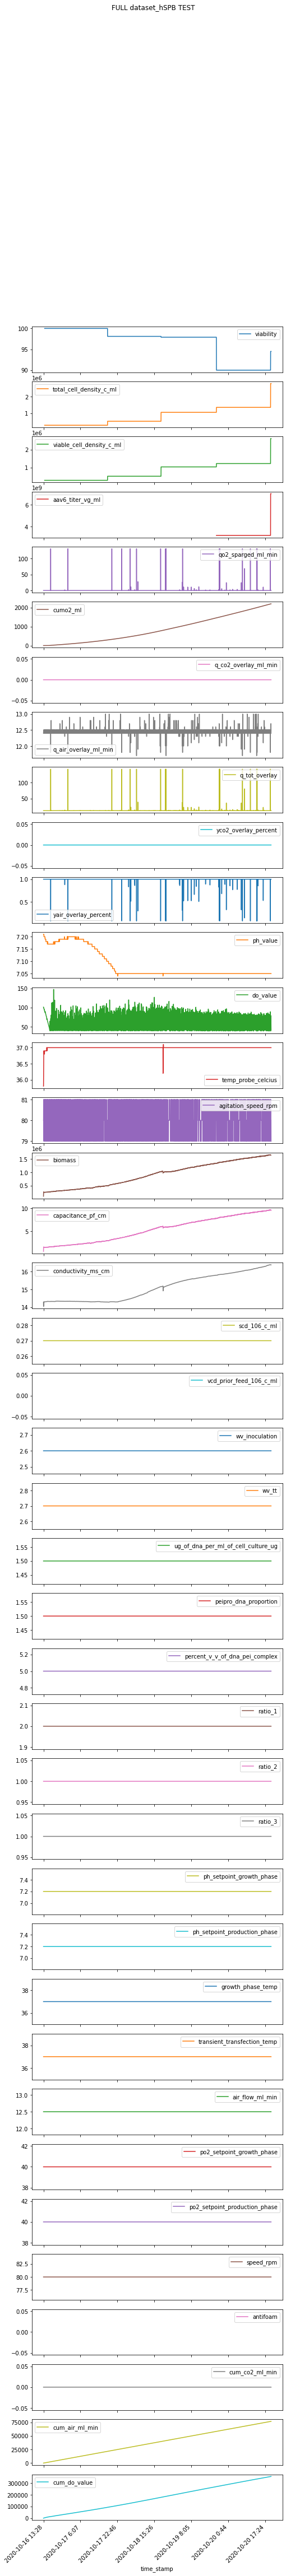

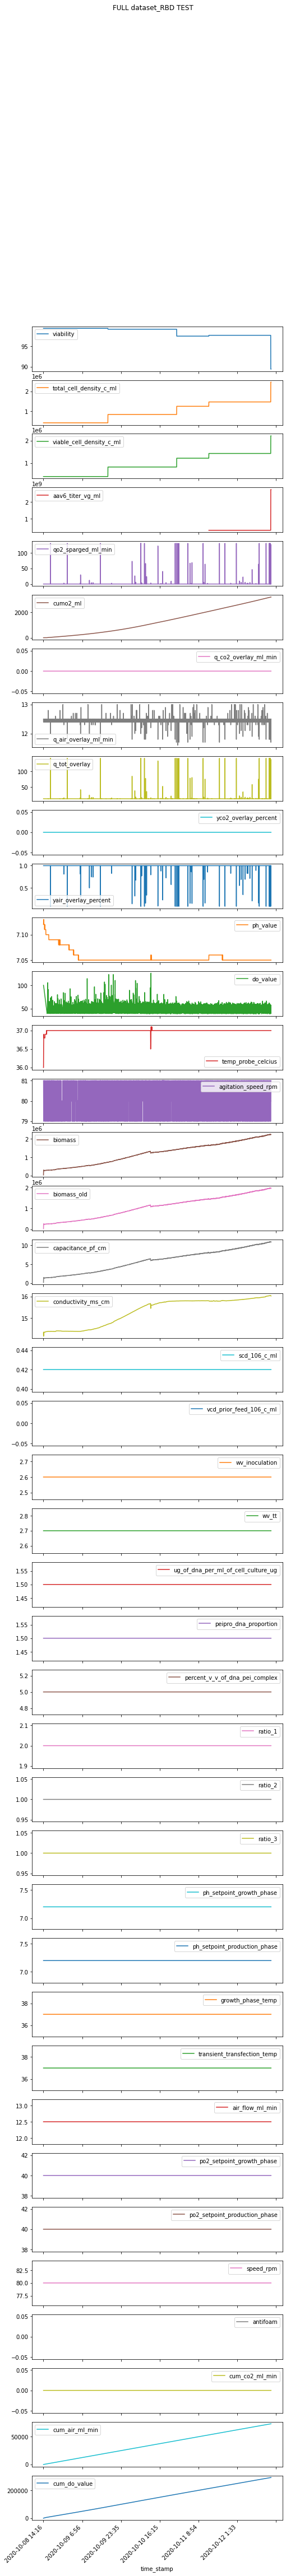

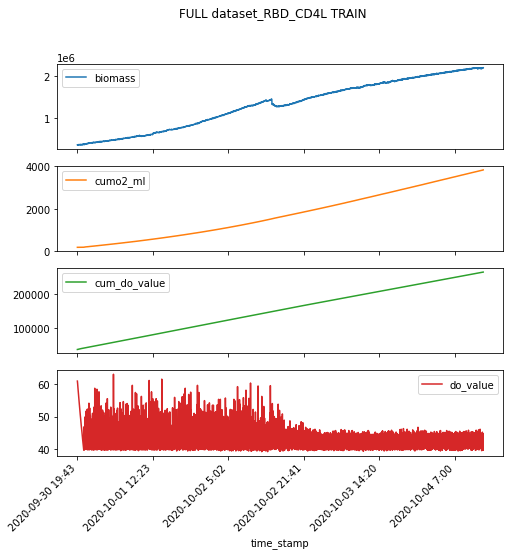

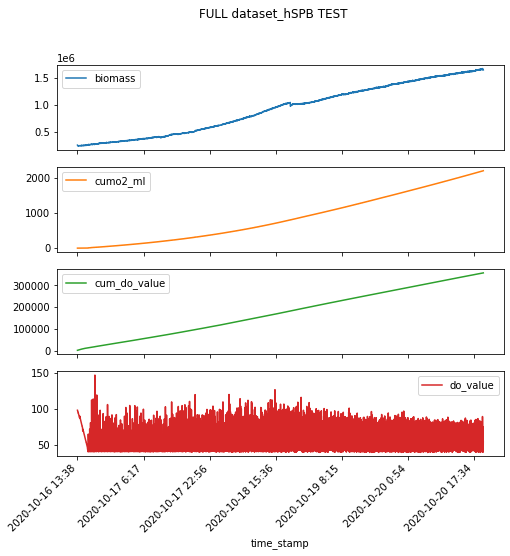

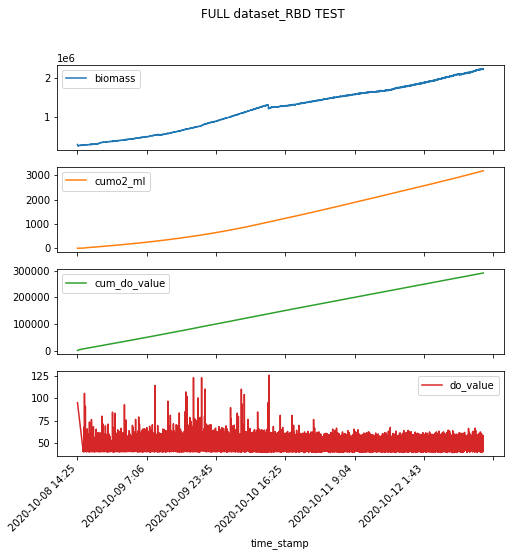

In [16]:
dataset_RBD_CD4L='/Users/cristovao/Devel/bioprocessesDT/dataset-AAV_amine/Bioreactor_dataset_AI4_project-AK-3L_AAV-RBD-CD4L.csv'
dataset_hSPB='/Users/cristovao/Devel/bioprocessesDT/dataset-AAV_amine/Bioreactor_dataset_AI4_project-AK-3L_AAV-hSPB.csv'
dataset_RBD='/Users/cristovao/Devel/bioprocessesDT/dataset-AAV_amine/Bioreactor_dataset_AI4_project-AK-3L_AAV-RBD.csv'

# load dataset
dataset_RBD_CD4L = read_csv(dataset_RBD_CD4L, header=0, index_col=0)
dataset_RBD_CD4L.info()
dataset_hSPB = read_csv(dataset_hSPB, header=0, index_col=0)
dataset_hSPB.info()
dataset_RBD = read_csv(dataset_RBD, header=0, index_col=0)
dataset_RBD.info()

cum_co2_ml=dataset_RBD_CD4L[['q_co2_overlay_ml_min']]
dataset_RBD_CD4L['cum_co2_ml_min']=cum_co2_ml.cumsum()
cum_co2_ml=dataset_hSPB[['q_co2_overlay_ml_min']]
dataset_hSPB['cum_co2_ml_min']=cum_co2_ml.cumsum()
cum_co2_ml=dataset_RBD[['q_co2_overlay_ml_min']]
dataset_RBD['cum_co2_ml_min']=cum_co2_ml.cumsum()

cum_co2_ml=dataset_RBD_CD4L[['q_air_overlay_ml_min']]
dataset_RBD_CD4L['cum_air_ml_min']=cum_co2_ml.cumsum()
cum_co2_ml=dataset_hSPB[['q_air_overlay_ml_min']]
dataset_hSPB['cum_air_ml_min']=cum_co2_ml.cumsum()
cum_co2_ml=dataset_RBD[['q_air_overlay_ml_min']]
dataset_RBD['cum_air_ml_min']=cum_co2_ml.cumsum()


cum_do_value=dataset_RBD_CD4L[['do_value']]
dataset_RBD_CD4L['cum_do_value']=cum_do_value.cumsum()
cum_do_value=dataset_hSPB[['do_value']]
dataset_hSPB['cum_do_value']=cum_do_value.cumsum()
cum_do_value=dataset_RBD[['do_value']]
dataset_RBD['cum_do_value']=cum_do_value.cumsum()


dataset_RBD_CD4L.plot(subplots=True,style='-',figsize=(8,80), title="FULL dataset_RBD_CD4L TRAIN")
plt.xticks(rotation=45)
dataset_hSPB.plot(subplots=True,style='-',figsize=(8,80), title="FULL dataset_hSPB TEST")
plt.xticks(rotation=45)
dataset_RBD.plot(subplots=True,style='-',figsize=(8,80), title="FULL dataset_RBD TEST")
plt.xticks(rotation=45)

# features=['biomass','cumo2_ml','ph_value','agitation_speed_rpm','temp_probe_celcius','q_co2_overlay_ml_min']
# features=['biomass','cumo2_ml','agitation_speed_rpm','do_value','q_co2_overlay_ml_min','cum_co2_ml_min','q_air_overlay_ml_min','cum_air_ml_min']
# features=['biomass','cumo2_ml','agitation_speed_rpm','do_value','cum_do_value','cum_air_ml_min']

features=['biomass','cumo2_ml','cum_do_value','do_value']

dataset_RBD_CD4L = dataset_RBD_CD4L.fillna(0)
dataset_RBD_CD4L.isnull().sum()


dt_RBD_CD4L=dataset_RBD_CD4L[features][400:5778] #2020-10-04  1:16:00 PM  
dt_hSPB=dataset_hSPB[features][10:6153]#['2020-10-16 14:28:47':'2020-10-20 19:55:00']  # 2020-10-20  7:55:00 PM
dt_RBD=dataset_RBD[features][10:5870]#['2020-10-08 15:16:00':'2020-10-12 16:02:00']  #2020-10-12  4:02:00 PM

dt_RBD_CD4L.plot(subplots=True,style='-',figsize=(8,8), title="FULL dataset_RBD_CD4L TRAIN")
plt.xticks(rotation=45)
dt_hSPB.plot(subplots=True,style='-',figsize=(8,8), title="FULL dataset_hSPB TEST")
plt.xticks(rotation=45)
dt_RBD.plot(subplots=True,style='-',figsize=(8,8), title="FULL dataset_RBD TEST")
plt.xticks(rotation=45)





# Normalized Dataset 

In [420]:
dataset_RBD_CD4L='/Users/cristovao/Devel/bioprocessesDT/dataset-AAV_amine/Bioreactor_dataset_AI4_project-AK-3L_AAV-RBD-CD4L.csv'
dataset_hSPB='/Users/cristovao/Devel/bioprocessesDT/dataset-AAV_amine/Bioreactor_dataset_AI4_project-AK-3L_AAV-hSPB.csv'
dataset_RBD='/Users/cristovao/Devel/bioprocessesDT/dataset-AAV_amine/Bioreactor_dataset_AI4_project-AK-3L_AAV-RBD.csv'

# load dataset
Ndataset_RBD_CD4L = read_csv(dataset_RBD_CD4L, header=0, index_col=0)
Ndataset_hSPB = read_csv(dataset_hSPB, header=0, index_col=0)
Ndataset_RBD = read_csv(dataset_RBD, header=0, index_col=0)


cum_do_value=Ndataset_RBD_CD4L[['do_value']]
Ndataset_RBD_CD4L['cum_do_value']=cum_do_value.cumsum()
cum_do_value=Ndataset_hSPB[['do_value']]
Ndataset_hSPB['cum_do_value']=cum_do_value.cumsum()
cum_do_value=Ndataset_RBD[['do_value']]
Ndataset_RBD['cum_do_value']=cum_do_value.cumsum()


# features=['biomass','cumo2_ml','agitation_speed_rpm','do_value','cum_air_ml_min']
features=['biomass','cumo2_ml','cum_do_value','do_value']#,'agitation_speed_rpm']


dt_RBD_CD4L_N=Ndataset_RBD_CD4L[features][400:5778]#['2020-09-30 14:00:00':'2020-10-04 13:21:16']  
dt_hSPB_N=Ndataset_hSPB[features][10:6153]#['2020-10-16 14:28:47':'2020-10-20 20:00:48']  
dt_RBD_N=Ndataset_RBD[features][10:5870]#['2020-10-08 15:16:00':'2020-10-12 16:06:40']  



print(dt_hSPB_N.shape)


dt_RBD_N = dt_RBD_N.fillna(0)
dt_RBD_N.isnull().sum()
print(dt_RBD_N.shape)


(6143, 4)
(5860, 4)


In [421]:
def normalize(X,min,max):
#     X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
    X_std = (X - min) / (max - min)
    return X_std

def inverse(X_std,min,max):
    X = X_std * (max - min) + min
    return X

In [422]:
dt_RBD.describe() 


,biomass,cumo2_ml,cum_do_value,do_value
count,5.860000e+03,5860.000000,5860.000000,5860.000000
mean,1.219822e+06,1320.070836,146866.425751,49.673106
std,5.806636e+05,971.093852,84145.258771,8.335057
min,2.636856e+05,0.000000,976.000000,39.000000
25%,6.470140e+05,411.800000,73074.375000,43.100000
50%,1.293310e+06,1188.900000,147387.400000,48.100000
75%,1.678074e+06,2159.600000,219905.225000,54.925000
max,2.248504e+06,3190.900000,291965.400000,125.900000


In [423]:
dt_hSPB.describe() 

,biomass,cumo2_ml,cum_do_value,do_value
count,6.143000e+03,6143.000000,6143.000000,6143.000000
mean,9.223419e+05,862.366515,175565.307749,58.025606
std,4.491151e+05,665.102512,104029.585204,16.187051
min,2.491688e+05,0.000000,1090.500000,38.900000
25%,4.694819e+05,249.000000,82801.750000,44.500000
50%,9.841738e+05,735.000000,172633.000000,52.800000
75%,1.325390e+06,1425.900000,266736.800000,69.650000
max,1.664379e+06,2192.300000,357443.700000,147.400000


In [424]:
dt_RBD_CD4L.describe()

,biomass,cumo2_ml,cum_do_value,do_value
count,5.378000e+03,5378.000000,5378.000000,5378.000000
mean,1.315044e+06,1736.878598,152311.879323,43.221290
std,5.784193e+05,1098.592488,67064.420356,3.308185
min,3.477825e+05,176.300000,34715.700000,39.200000
25%,7.537492e+05,732.700000,94148.025000,40.800000
50%,1.349211e+06,1609.800000,153437.400000,42.500000
75%,1.838024e+06,2681.200000,210431.225000,44.500000
max,2.202799e+06,3829.100000,267098.900000,63.000000


In [425]:
dt_RBD_N['biomass']=normalize(dt_RBD['biomass'],249168.775,2248504.329)
dt_RBD_N['cumo2_ml']=normalize(dt_RBD['cumo2_ml'],0.0,3829.100)
# dt_RBD_N['agitation_speed_rpm']=normalize(dt_RBD['agitation_speed_rpm'],79.000,100.00)
dt_RBD_N['do_value']=normalize(dt_RBD['do_value'],39.0,147.400)
dt_RBD_N['cum_do_value']=normalize(dt_RBD['cum_do_value'],976.0000,357443.700)

dt_hSPB_N['biomass']=normalize(dt_hSPB['biomass'],249168.775,2248504.329)
dt_hSPB_N['cumo2_ml']=normalize(dt_hSPB['cumo2_ml'],0.0,3829.100)
# dt_hSPB_N['agitation_speed_rpm']=normalize(dt_hSPB['agitation_speed_rpm'],79.000,100.00)
dt_hSPB_N['do_value']=normalize(dt_hSPB['do_value'],39.0,147.400)
dt_hSPB_N['cum_do_value']=normalize(dt_hSPB['cum_do_value'],7976.0000,357443.700)

dt_RBD_CD4L_N['biomass']=normalize(dt_RBD_CD4L['biomass'],249168.775,2248504.329)
dt_RBD_CD4L_N['cumo2_ml']=normalize(dt_RBD_CD4L['cumo2_ml'],0.0,3829.100)
# dt_RBD_CD4L_N['agitation_speed_rpm']=normalize(dt_RBD_CD4L['agitation_speed_rpm'],79.000,100.00)
dt_RBD_CD4L_N['do_value']=normalize(dt_RBD_CD4L['do_value'],39.0,147.400)
dt_RBD_CD4L_N['cum_do_value']=normalize(dt_RBD_CD4L['cum_do_value'],976.0000,357443.700)


In [426]:
dt_RBD_N.describe()

,biomass,cumo2_ml,cum_do_value,do_value
count,5860.000000,5860.000000,5860.000000,5860.000000
mean,0.485488,0.344747,0.409267,0.098460
std,0.290428,0.253609,0.236053,0.076892
min,0.007261,0.000000,0.000000,0.000000
25%,0.198989,0.107545,0.202258,0.037823
50%,0.522244,0.310491,0.410728,0.083948
75%,0.714690,0.563997,0.614163,0.146910
max,1.000000,0.833329,0.816314,0.801661


In [427]:
dt_hSPB_N.describe()

,biomass,cumo2_ml,cum_do_value,do_value
count,6143.000000,6143.000000,6143.000000,6143.000000
mean,0.336698,0.225214,0.479556,0.175513
std,0.224632,0.173697,0.297680,0.149327
min,0.000000,0.000000,-0.019703,-0.000923
25%,0.110193,0.065028,0.214113,0.050738
50%,0.367625,0.191951,0.471165,0.127306
75%,0.538289,0.372385,0.740443,0.282749
max,0.707840,0.572537,1.000000,1.000000


In [428]:
dt_RBD_CD4L_N.describe()

,biomass,cumo2_ml,cum_do_value,do_value
count,5378.000000,5378.000000,5378.000000,5378.000000
mean,0.533115,0.453600,0.424543,0.038942
std,0.289306,0.286906,0.188136,0.030518
min,0.049323,0.046042,0.094650,0.001845
25%,0.252374,0.191350,0.261376,0.016605
50%,0.550204,0.420412,0.427700,0.032288
75%,0.794692,0.700217,0.587585,0.050738
max,0.977140,1.000000,0.746555,0.221402


# Save in CSV file the dataset normalized

In [348]:

dt_RBD_N.to_csv (r'dataset_RBD_Normalized.csv', index = True, header=True)
dt_RBD_CD4L_N.to_csv (r'dataset_RBD_CD4L_Normalized.csv', index = True, header=True)
dt_hSPB_N.to_csv (r'dataset_hSPB_Normalized.csv', index = True, header=True)



# dataset normalized RBD_CD4L and hSPB

/usr/local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


(array([-2000.,     0.,  2000.,  4000.,  6000.,  8000., 10000., 12000.,
        14000.]),
 [Text(-2000.0, 0, '2020-10-19 10:38'),
  Text(0.0, 0, '2020-09-30 19:43'),
  Text(2000.0, 0, '2020-10-02 5:02'),
  Text(4000.0, 0, '2020-10-03 14:20'),
  Text(6000.0, 0, '2020-10-16 23:59'),
  Text(8000.0, 0, '2020-10-18 9:18'),
  Text(10000.0, 0, '2020-10-19 18:37'),
  Text(12000.0, 0, ''),
  Text(14000.0, 0, '')])

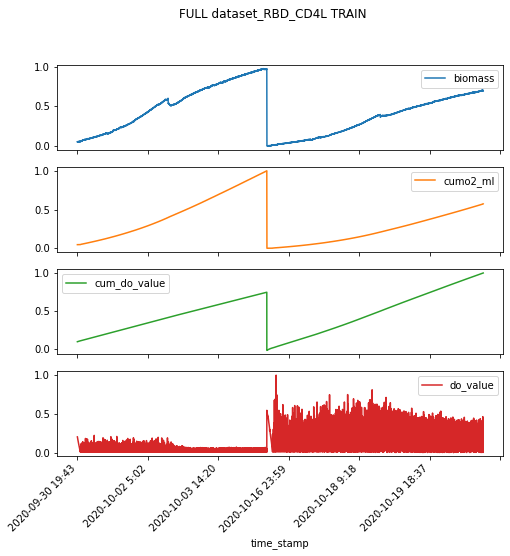

In [429]:
df0=read_csv('dataset_RBD_CD4L_Normalized.csv', header=0, index_col=0)
df1=read_csv('dataset_hSPB_Normalized.csv', header=0, index_col=0)
all_datasets=df0.append(df1)

all_datasets.to_csv(r'all_dt_RBDCD4L_hSPB_Normalized.csv', index = True, header=True)

all_datasets.plot(subplots=True,style='-',figsize=(8,8), title="FULL dataset_RBD_CD4L TRAIN")
plt.xticks(rotation=45)

# Offline dataset 

## RBD

In [213]:
# 08-Oct-2020 13:53 - 1
# 09-Oct-2020 18:00 - 1656
# 10-Oct-2020 23:34 - 2711
# 11-Oct-2020 13:23 - 4262
# 12-Oct-2020 16:00 - 5860

    
idxtime_RBD=[1.,1656.,2711.,4262.,5860.]    
    
Total_Cell_Density_RBD=[
415771.1102,
836933.5962,
1254799.111,
1465385.659,
2466498.954]

Viable_Cell_Density_RBD=[
406950.6956,
830318.3151,
1223927.72,
1431206.687,
2205195.053]

# RBD_CD4L

In [197]:

# Date
# 30-Sep-2020 13:19 - 1 
# 01-Oct-2020 13:16 - 1056
# 02-Oct-2020 13:39 -
# 03-Oct-2020 10:04 -
# 04-Oct-2020 12:44 -
    
idxtime_RBD_CD4L=[1,1056,2520,3745,5347]

Total_Cell_Density_RBD_CD4L=[
323146.4458,
683679.5045,
1335285.051,
575629.8138,
1228337.987]

Viable_Cell_Density_RBD_CD4L=[
318736.2386,
669346.3756,
1276850.088,
516092.2242,
1032084.448]

# hSPB

In [198]:
# Date
# 16-Oct-2020 13:58 - 22
# 17-Oct-2020 18:20 - 1726
# 18-Oct-2020 18:26 - 3173
# 19-Oct-2020 19:23 - 4671
# 20-Oct-2020 19:48 - 6137

idxtime_hSPB=[1,1056,2520,3745,5347]

Total_Cell_Density_hSPB=[
271326.7041,
511682.0765,
1054135.425,
1354028.447,
2785135.133]

Viable_Cell_Density_hSPB=[
271326.7041,
501759.1549,
1032084.448,
1218415.005,
2631881.101]

# Biomass estimation by GPR from offline measurements 

/usr/local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


(array([-1000.,     0.,  1000.,  2000.,  3000.,  4000.,  5000.,  6000.,
         7000.]),
 [Text(-1000.0, 0, '2020-10-20 3:17'),
  Text(0.0, 0, '2020-10-16 13:38'),
  Text(1000.0, 0, '2020-10-17 6:17'),
  Text(2000.0, 0, '2020-10-17 22:56'),
  Text(3000.0, 0, '2020-10-18 15:36'),
  Text(4000.0, 0, '2020-10-19 8:15'),
  Text(5000.0, 0, '2020-10-20 0:54'),
  Text(6000.0, 0, '2020-10-20 17:34'),
  Text(7000.0, 0, '')])

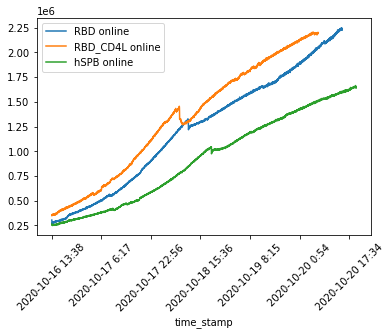

In [201]:
plt.plot(dt_RBD[['biomass']].values)
dt_RBD_CD4L['biomass'].plot()
dt_hSPB['biomass'].plot()
plt.legend(['RBD online', 'RBD_CD4L online', 'hSPB online'])
plt.xticks(rotation=45)


# RBD biomass estimation by GPR from offline points

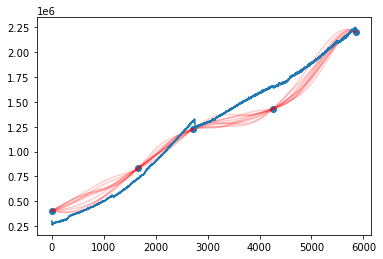

In [229]:
import numpy as np
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

tf.enable_v2_behavior()

tfb = tfp.bijectors
tfd = tfp.distributions
psd_kernels = tfp.math.psd_kernels

# Generate noisy observations from a known function at some random points.
# observation_noise_variance = 0.
observation_noise_variance = 0.016 #tfp.util.TransformedVariable(np.exp(-5), tfb.Exp(), name='observation_noise_variance')

maxvalue=5860.

# plt.scatter(idxtime_RBD,Viable_Cell_Density_RBD,c='r')


observation_index_points = np.array(idxtime_RBD)[:, np.newaxis]
observations = np.array(Viable_Cell_Density_RBD)#[:, np.newaxis]


index_points = np.linspace(1., maxvalue, 5860)[..., np.newaxis]

# kernel = psd_kernels.MaternFiveHalves()
# kernel = psd_kernels.RationalQuadratic()

amplitude = tfp.util.TransformedVariable(
  108050.003, tfb.Exp(), dtype=tf.float64, name='amplitude')
length_scale = tfp.util.TransformedVariable(
  865., tfb.Exp(), dtype=tf.float64, name='length_scale')
kernel = psd_kernels.RationalQuadratic(amplitude, length_scale)

gprm = tfd.GaussianProcessRegressionModel(
    kernel=kernel,
    index_points=index_points,
    observation_index_points=observation_index_points,
    observations=observations,
    observation_noise_variance=observation_noise_variance)

# samples = gprm.sample(10)

samples_RBD_biomass_offline_values = gprm.sample(10).numpy()
# ==> 10 independently drawn, joint samples at `index_points`.
samples=samples_RBD_biomass_offline_values
import matplotlib.pyplot as plt
plt.scatter(np.squeeze(observation_index_points), observations)
plt.plot(np.stack([index_points[:, 0]]*10).T, samples.T, c='r', alpha=.2)
plt.plot(dt_RBD[['biomass']].values)


### create 10 dt from the biomass estimated from GPR

In [230]:
for i in range(10):
    dt = read_csv('dataset_RBD_Normalized.csv', header=0, index_col=0)
    dt['biomass']=normalize(samples_RBD_biomass_offline_values.T[:,i],249168.775,2248504.329)
    dt.to_csv(r'dt_'+str(i)+'_RBD_Normalized_from_offline_values.csv', index = True, header=True)

### create only one dataset from the 10 datasets

/usr/local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


(array([-10000.,      0.,  10000.,  20000.,  30000.,  40000.,  50000.,
         60000.,  70000.]),
 [Text(-10000.0, 0, '2020-10-09 19:05'),
  Text(0.0, 0, '2020-10-08 14:25'),
  Text(10000.0, 0, '2020-10-11 11:24'),
  Text(20000.0, 0, '2020-10-10 6:45'),
  Text(30000.0, 0, '2020-10-09 2:06'),
  Text(40000.0, 0, '2020-10-11 23:03'),
  Text(50000.0, 0, '2020-10-10 18:25'),
  Text(60000.0, 0, ''),
  Text(70000.0, 0, '')])

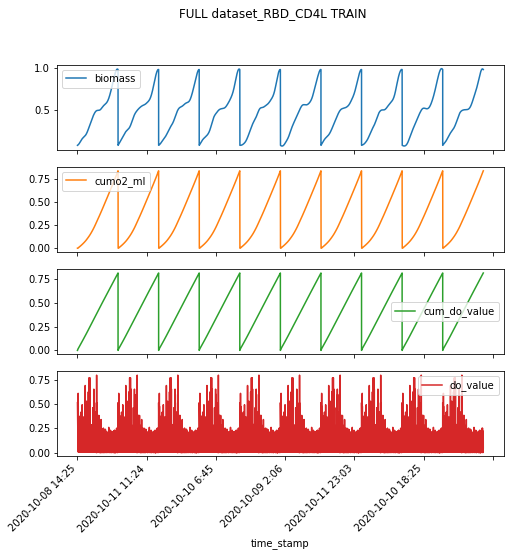

In [231]:
import numpy as np
import pandas as pd

all_dt=[]
df0=read_csv('dt_0_RBD_Normalized_from_offline_values.csv', header=0, index_col=0)
for i in range(1,10):
    all_dt.append(read_csv('dt_'+str(i)+'_RBD_Normalized_from_offline_values.csv', header=0, index_col=0))

all_datasets=df0.append(all_dt)
all_datasets.to_csv(r'all_dt_RBD_Normalized_from_offline_values.csv', index = True, header=True)

all_datasets.plot(subplots=True,style='-',figsize=(8,8), title="FULL dataset_RBD_CD4L TRAIN")
plt.xticks(rotation=45)

# Biomass estimation by GPR from points selection 

In [4]:
dt_RBD_CD4L['biomass'].to_csv (r'dataset_RBD_CD4L_with_observed_biomass.csv', index = True, header=True)
dt_hSPB['biomass'].to_csv (r'dataset_hSPB_with_observed_biomass.csv', index = True, header=True)
dt_RBD['biomass'].to_csv (r'dataset_RBD_with_observed_biomass.csv', index = True, header=True)
dt_RBD_to_select_points = read_csv('dataset_RBD_with_observed_biomass.csv', header=0, index_col=0)
dt_RBD_CD4L_to_select_points = read_csv('dataset_RBD_CD4L_with_observed_biomass.csv', header=0, index_col=0)
dt_hSPB_to_select_points = read_csv('dataset_hSPB_with_observed_biomass.csv', header=0, index_col=0)

In [272]:
dt_RBD_to_select_points.info()
dt_RBD_CD4L_to_select_points.info()
dt_hSPB_to_select_points.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5860 entries, 2020-10-08 14:25 to 2020-10-12 16:01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   biomass  5860 non-null   float64
dtypes: float64(1)
memory usage: 91.6+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 5378 entries, 2020-09-30 19:43 to 2020-10-04 13:16
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   biomass  5378 non-null   float64
dtypes: float64(1)
memory usage: 84.0+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 6143 entries, 2020-10-16 13:38 to 2020-10-20 19:55
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   biomass  6143 non-null   float64
dtypes: float64(1)
memory usage: 96.0+ KB


#  5 points

### data from 3L dataset bioreactor

In [318]:
idx_of_RBD_biomass_5_values_selected=[   1,    1573,  2701,  4501, 5851]
RBD_biomass_5_values_selected=[]
for i in idx_of_RBD_biomass_5_values_selected:
    RBD_biomass_5_values_selected.append(dt_RBD_to_select_points['biomass'].iloc[i])
idx_of_RBD_biomass_5_values_selected=np.array([   1.,    1573.,  2701.,  4501., 5851.])[:, np.newaxis]

idx_of_RBD_CD4L_biomass_5_values_selected=[   1,    1576,  2551,  3926, 5376]
RBD_CD4L_biomass_5_values_selected=[]
for i in idx_of_RBD_CD4L_biomass_5_values_selected:
    RBD_CD4L_biomass_5_values_selected.append(dt_RBD_CD4L_to_select_points['biomass'].iloc[i])
idx_of_RBD_CD4L_biomass_5_values_selected=np.array([   1.,    1576., 2551., 3926.,  5376.])[:, np.newaxis]

idx_of_hSPB_biomass_5_values_selected=[   1,    1573,  3206,  4501, 6141]
hSPB_biomass_5_values_selected=[]
for i in idx_of_hSPB_biomass_5_values_selected:
    hSPB_biomass_5_values_selected.append(dt_hSPB_to_select_points['biomass'].iloc[i])
idx_of_hSPB_biomass_5_values_selected=np.array([   1.,    1573.,  3206.,  4501., 6141.])[:, np.newaxis]



In [5]:
idx_of_RBD_biomass_5_values_selected=[   1,    1573,  2701,  4501, 5851]
RBD_biomass_5_values_selected=[]
for i in idx_of_RBD_biomass_5_values_selected:
    RBD_biomass_5_values_selected.append(dt_RBD_to_select_points['biomass'].iloc[i])
idx_of_RBD_biomass_5_values_selected=np.array([   1.,    1573.,  2701.,  4501., 5851.])[:, np.newaxis]

idx_of_RBD_CD4L_biomass_5_values_selected=[   1,    1576,  2551,  3926, 5376]
RBD_CD4L_biomass_5_values_selected=[]
for i in idx_of_RBD_CD4L_biomass_5_values_selected:
    RBD_CD4L_biomass_5_values_selected.append(dt_RBD_CD4L_to_select_points['biomass'].iloc[i])
idx_of_RBD_CD4L_biomass_5_values_selected=np.array([   1.,    1576., 2551., 3926.,  5376.])[:, np.newaxis]

idx_of_hSPB_biomass_5_values_selected=[   1,    1573,  3206,  4501, 6141]
hSPB_biomass_5_values_selected=[]
for i in idx_of_hSPB_biomass_5_values_selected:
    hSPB_biomass_5_values_selected.append(dt_hSPB_to_select_points['biomass'].iloc[i])
idx_of_hSPB_biomass_5_values_selected=np.array([   1.,    1573.,  3206.,  4501., 6141.])[:, np.newaxis]



(array([-1000.,     0.,  1000.,  2000.,  3000.,  4000.,  5000.,  6000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

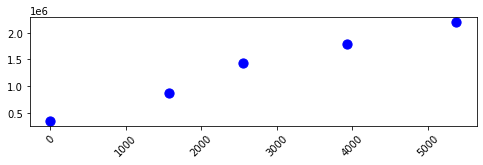

In [33]:
plt.figure(figsize=(8, 2))
# dt_RBD_to_select_points.plot()
# dt_RBD_CD4L['biomass'].plot()
# dt_hSPB['biomass'].plot()
# plt.scatter(idx_of_RBD_biomass_5_values_selected,RBD_biomass_5_values_selected,c='b')


plt.scatter(idx_of_RBD_CD4L_biomass_5_values_selected,RBD_CD4L_biomass_5_values_selected,c='blue',s=85)
# plt.scatter(idx_of_hSPB_biomass_5_values_selected,hSPB_biomass_5_values_selected,c='g')

# plt.legend(['RBD_CD4L', 'hSPB','RBD selected points','RBD_CD4L selected points','hSPB selected points'])
plt.xticks(rotation=45)


(array([-1000.,     0.,  1000.,  2000.,  3000.,  4000.,  5000.,  6000.,
         7000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

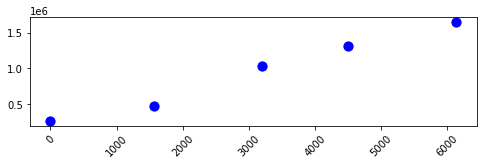

In [32]:
# plt.scatter(idx_of_RBD_biomass_5_values_selected,RBD_biomass_5_values_selected,c='b')
# plt.scatter(idx_of_RBD_CD4L_biomass_5_values_selected,RBD_CD4L_biomass_5_values_selected,c='orange')
plt.figure(figsize=(8, 2))

# dt_RBD_to_select_points.plot()
# dt_RBD_CD4L['biomass'].plot()
# dt_hSPB['biomass'].plot()
plt.scatter(idx_of_hSPB_biomass_5_values_selected,hSPB_biomass_5_values_selected,c='blue',s=85)

# plt.legend([ 'hSPB','RBD selected points','RBD_CD4L selected points','hSPB selected points'])
plt.xticks(rotation=45)

/usr/local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


(array([-1000.,     0.,  1000.,  2000.,  3000.,  4000.,  5000.,  6000.,
         7000.]),
 [Text(-1000.0, 0, '2020-10-20 3:17'),
  Text(0.0, 0, '2020-10-16 13:38'),
  Text(1000.0, 0, '2020-10-17 6:17'),
  Text(2000.0, 0, '2020-10-17 22:56'),
  Text(3000.0, 0, '2020-10-18 15:36'),
  Text(4000.0, 0, '2020-10-19 8:15'),
  Text(5000.0, 0, '2020-10-20 0:54'),
  Text(6000.0, 0, '2020-10-20 17:34'),
  Text(7000.0, 0, '')])

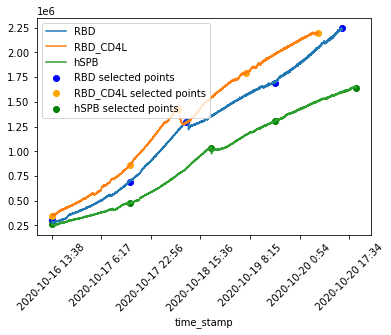

In [319]:
dt_RBD_to_select_points.plot()
dt_RBD_CD4L['biomass'].plot()
dt_hSPB['biomass'].plot()
plt.scatter(idx_of_RBD_biomass_5_values_selected,RBD_biomass_5_values_selected,c='b')
plt.scatter(idx_of_RBD_CD4L_biomass_5_values_selected,RBD_CD4L_biomass_5_values_selected,c='orange')
plt.scatter(idx_of_hSPB_biomass_5_values_selected,hSPB_biomass_5_values_selected,c='g')

plt.legend(['RBD', 'RBD_CD4L', 'hSPB','RBD selected points','RBD_CD4L selected points','hSPB selected points'])
plt.xticks(rotation=45)


/usr/local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


(array([-1000.,     0.,  1000.,  2000.,  3000.,  4000.,  5000.,  6000.,
         7000.]),
 [Text(-1000.0, 0, '2020-10-11 23:23'),
  Text(0.0, 0, '2020-10-08 14:25'),
  Text(1000.0, 0, '2020-10-09 7:06'),
  Text(2000.0, 0, '2020-10-09 23:45'),
  Text(3000.0, 0, '2020-10-10 16:25'),
  Text(4000.0, 0, '2020-10-11 9:04'),
  Text(5000.0, 0, '2020-10-12 1:43'),
  Text(6000.0, 0, ''),
  Text(7000.0, 0, '')])

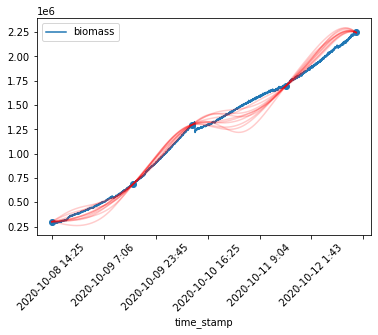

In [333]:
import numpy as np
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

tf.enable_v2_behavior()

tfb = tfp.bijectors
tfd = tfp.distributions
psd_kernels = tfp.math.psd_kernels

# Generate noisy observations from a known function at some random points.
# observation_noise_variance = 0.
observation_noise_variance = 0.016 #tfp.util.TransformedVariable(np.exp(-5), tfb.Exp(), name='observation_noise_variance')

maxvalue=5860.
observation_index_points = idx_of_RBD_biomass_5_values_selected
observations = np.array(RBD_biomass_5_values_selected)#[:, np.newaxis]


index_points = np.linspace(1., maxvalue, 5860)[..., np.newaxis]

# kernel = psd_kernels.MaternFiveHalves()
# kernel = psd_kernels.RationalQuadratic()

amplitude = tfp.util.TransformedVariable(
  108050.003, tfb.Exp(), dtype=tf.float64, name='amplitude')
length_scale = tfp.util.TransformedVariable(
  865., tfb.Exp(), dtype=tf.float64, name='length_scale')
kernel = psd_kernels.RationalQuadratic(amplitude, length_scale)

gprm = tfd.GaussianProcessRegressionModel(
    kernel=kernel,
    index_points=index_points,
    observation_index_points=observation_index_points,
    observations=observations,
    observation_noise_variance=observation_noise_variance)

# samples = gprm.sample(10)

samples_RBD_biomass_5_values_selected = gprm.sample(10).numpy()
# ==> 10 independently drawn, joint samples at `index_points`.
samples=samples_RBD_biomass_5_values_selected
import matplotlib.pyplot as plt
dt_RBD_to_select_points.plot()
plt.scatter(np.squeeze(observation_index_points), observations)
plt.plot(np.stack([index_points[:, 0]]*10).T, samples.T, c='r', alpha=.2)
plt.xticks(rotation=45)


(array([-1000.,     0.,  1000.,  2000.,  3000.,  4000.,  5000.,  6000.,
         7000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

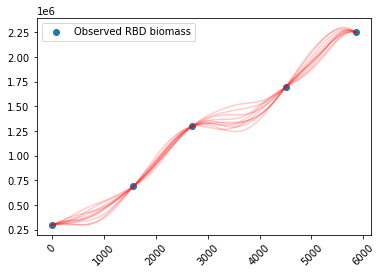

In [405]:
import numpy as np
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

tf.enable_v2_behavior()

tfb = tfp.bijectors
tfd = tfp.distributions
psd_kernels = tfp.math.psd_kernels

# Generate noisy observations from a known function at some random points.
# observation_noise_variance = 0.
observation_noise_variance = 0.016 #tfp.util.TransformedVariable(np.exp(-5), tfb.Exp(), name='observation_noise_variance')

maxvalue=5860.
observation_index_points = idx_of_RBD_biomass_5_values_selected
observations = np.array(RBD_biomass_5_values_selected)#[:, np.newaxis]


index_points = np.linspace(1., maxvalue, 5860)[..., np.newaxis]

# kernel = psd_kernels.MaternFiveHalves()
# kernel = psd_kernels.RationalQuadratic()

amplitude = tfp.util.TransformedVariable(
  108050.003, tfb.Exp(), dtype=tf.float64, name='amplitude')
length_scale = tfp.util.TransformedVariable(
  865., tfb.Exp(), dtype=tf.float64, name='length_scale')
kernel = psd_kernels.RationalQuadratic(amplitude, length_scale)

gprm = tfd.GaussianProcessRegressionModel(
    kernel=kernel,
    index_points=index_points,
    observation_index_points=observation_index_points,
    observations=observations,
    observation_noise_variance=observation_noise_variance)

# samples = gprm.sample(10)

samples_RBD_biomass_5_values_selected = gprm.sample(10).numpy()
# ==> 10 independently drawn, joint samples at `index_points`.
samples=samples_RBD_biomass_5_values_selected
import matplotlib.pyplot as plt
# dt_RBD_to_select_points.plot()
plt.scatter(np.squeeze(observation_index_points), observations)
plt.legend(['Observed RBD biomass'])
plt.plot(np.stack([index_points[:, 0]]*10).T, samples.T, c='r', alpha=.2)
# plt.legend(['GPR samples 1','GPR sample 2','GPR sample 3','GPR sample 4','GPR sample 5',
#              'GPR sample 6','GPR sample 7','GPR sample 8','GPR sample 9','GPR sample 10','Observed RBD biomass'])
plt.xticks(rotation=45)

/usr/local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


(array([-1000.,     0.,  1000.,  2000.,  3000.,  4000.,  5000.,  6000.]),
 [Text(-1000.0, 0, '2020-10-03 20:38'),
  Text(0.0, 0, '2020-09-30 19:43'),
  Text(1000.0, 0, '2020-10-01 12:23'),
  Text(2000.0, 0, '2020-10-02 5:02'),
  Text(3000.0, 0, '2020-10-02 21:41'),
  Text(4000.0, 0, '2020-10-03 14:20'),
  Text(5000.0, 0, '2020-10-04 7:00'),
  Text(6000.0, 0, '')])

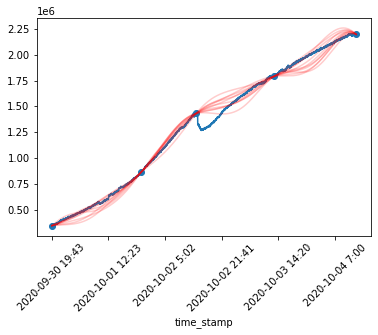

In [336]:
import numpy as np
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

tf.enable_v2_behavior()

tfb = tfp.bijectors
tfd = tfp.distributions
psd_kernels = tfp.math.psd_kernels

# Generate noisy observations from a known function at some random points.
# observation_noise_variance = 0.
observation_noise_variance = 0.016 #tfp.util.TransformedVariable(np.exp(-5), tfb.Exp(), name='observation_noise_variance')

maxvalue=5378.
observation_index_points = idx_of_RBD_CD4L_biomass_5_values_selected
observations = np.array(RBD_CD4L_biomass_5_values_selected)#[:, np.newaxis]

index_points = np.linspace(1., maxvalue, 5378)[..., np.newaxis]

# kernel = psd_kernels.MaternFiveHalves()
# kernel = psd_kernels.RationalQuadratic()

amplitude = tfp.util.TransformedVariable(
  108050.003, tfb.Exp(), dtype=tf.float64, name='amplitude')
length_scale = tfp.util.TransformedVariable(
  765., tfb.Exp(), dtype=tf.float64, name='length_scale')
kernel = psd_kernels.RationalQuadratic(amplitude, length_scale)

gprm = tfd.GaussianProcessRegressionModel(
    kernel=kernel,
    index_points=index_points,
    observation_index_points=observation_index_points,
    observations=observations,
    observation_noise_variance=observation_noise_variance)

# samples = gprm.sample(10)

samples_RBD_CD4L_biomass_5_values_selected = gprm.sample(10).numpy()
# ==> 10 independently drawn, joint samples at `index_points`.
samples=samples_RBD_CD4L_biomass_5_values_selected
import matplotlib.pyplot as plt
dt_RBD_CD4L['biomass'].plot()
plt.scatter(np.squeeze(observation_index_points), observations)
plt.plot(np.stack([index_points[:, 0]]*10).T, samples.T, c='r', alpha=.2)
plt.xticks(rotation=45)


(array([-1000.,     0.,  1000.,  2000.,  3000.,  4000.,  5000.,  6000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

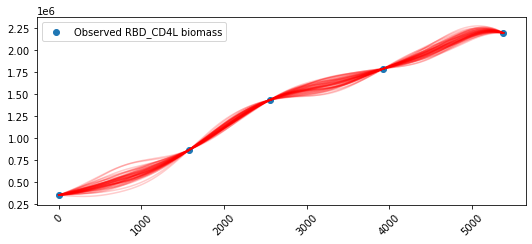

In [1128]:
import numpy as np
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

tf.enable_v2_behavior()

tfb = tfp.bijectors
tfd = tfp.distributions
psd_kernels = tfp.math.psd_kernels

# Generate noisy observations from a known function at some random points.
# observation_noise_variance = 0.
observation_noise_variance = 0.016 #tfp.util.TransformedVariable(np.exp(-5), tfb.Exp(), name='observation_noise_variance')

maxvalue=5378.
observation_index_points = idx_of_RBD_CD4L_biomass_5_values_selected
observations = np.array(RBD_CD4L_biomass_5_values_selected)#[:, np.newaxis]

index_points = np.linspace(1., maxvalue, 5378)[..., np.newaxis]

# kernel = psd_kernels.MaternFiveHalves()
# kernel = psd_kernels.RationalQuadratic()

amplitude = tfp.util.TransformedVariable(
  108050.003, tfb.Exp(), dtype=tf.float64, name='amplitude')
length_scale = tfp.util.TransformedVariable(
  900., tfb.Exp(), dtype=tf.float64, name='length_scale')
kernel = psd_kernels.RationalQuadratic(amplitude, length_scale)

gprm = tfd.GaussianProcessRegressionModel(
    kernel=kernel,
    index_points=index_points,
    observation_index_points=observation_index_points,
    observations=observations,
    observation_noise_variance=observation_noise_variance)

# samples = gprm.sample(10)
nsamples=50
samples_RBD_CD4L_biomass_5_values_selected = gprm.sample(nsamples).numpy()
# ==> 10 independently drawn, joint samples at `index_points`.
samples=samples_RBD_CD4L_biomass_5_values_selected
import matplotlib.pyplot as plt
# dt_RBD_CD4L['biomass'].plot()
plt.scatter(np.squeeze(observation_index_points), observations)
plt.legend(['Observed RBD_CD4L biomass'])

plt.plot(np.stack([index_points[:, 0]]*nsamples).T, samples.T, c='r', alpha=.2)
plt.xticks(rotation=45)


/usr/local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


(array([-1000.,     0.,  1000.,  2000.,  3000.,  4000.,  5000.,  6000.,
         7000.]),
 [Text(-1000.0, 0, '2020-10-20 3:17'),
  Text(0.0, 0, '2020-10-16 13:38'),
  Text(1000.0, 0, '2020-10-17 6:17'),
  Text(2000.0, 0, '2020-10-17 22:56'),
  Text(3000.0, 0, '2020-10-18 15:36'),
  Text(4000.0, 0, '2020-10-19 8:15'),
  Text(5000.0, 0, '2020-10-20 0:54'),
  Text(6000.0, 0, '2020-10-20 17:34'),
  Text(7000.0, 0, '')])

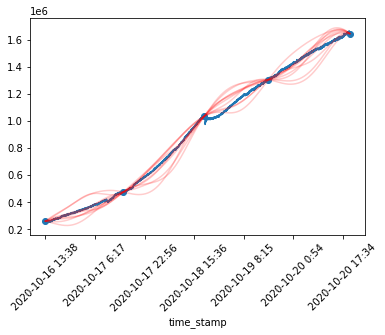

In [1009]:
import numpy as np
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

tf.enable_v2_behavior()

tfb = tfp.bijectors
tfd = tfp.distributions
psd_kernels = tfp.math.psd_kernels

# Generate noisy observations from a known function at some random points.
# observation_noise_variance = 0.
observation_noise_variance = 0.016 #tfp.util.TransformedVariable(np.exp(-5), tfb.Exp(), name='observation_noise_variance')

maxvalue=6143.
observation_index_points = idx_of_hSPB_biomass_5_values_selected
observations = np.array(hSPB_biomass_5_values_selected)#[:, np.newaxis]
# idx_of_hSPB_biomass_5_values_selected,hSPB_biomass_5_values_selected

index_points = np.linspace(1., maxvalue, 6143)[..., np.newaxis]

# kernel = psd_kernels.MaternFiveHalves()
# kernel = psd_kernels.RationalQuadratic()

amplitude = tfp.util.TransformedVariable(
  108050.003, tfb.Exp(), dtype=tf.float64, name='amplitude')
length_scale = tfp.util.TransformedVariable(
  865., tfb.Exp(), dtype=tf.float64, name='length_scale')
kernel = psd_kernels.RationalQuadratic(amplitude, length_scale)

gprm = tfd.GaussianProcessRegressionModel(
    kernel=kernel,
    index_points=index_points,
    observation_index_points=observation_index_points,
    observations=observations,
    observation_noise_variance=observation_noise_variance)

# samples = gprm.sample(10)

samples_hSPB_biomass_5_values_selected = gprm.sample(10).numpy()
# ==> 10 independently drawn, joint samples at `index_points`.
samples=samples_hSPB_biomass_5_values_selected
import matplotlib.pyplot as plt
dt_hSPB['biomass'].plot()
plt.scatter(np.squeeze(observation_index_points), observations)
plt.plot(np.stack([index_points[:, 0]]*10).T, samples.T, c='r', alpha=.2)
plt.xticks(rotation=45)


(array([-1000.,     0.,  1000.,  2000.,  3000.,  4000.,  5000.,  6000.,
         7000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

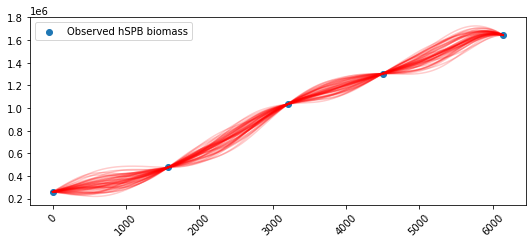

In [1129]:
import numpy as np
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

tf.enable_v2_behavior()

tfb = tfp.bijectors
tfd = tfp.distributions
psd_kernels = tfp.math.psd_kernels

# Generate noisy observations from a known function at some random points.
# observation_noise_variance = 0.
observation_noise_variance = 0.016 #tfp.util.TransformedVariable(np.exp(-5), tfb.Exp(), name='observation_noise_variance')

maxvalue=6143.
observation_index_points = idx_of_hSPB_biomass_5_values_selected
observations = np.array(hSPB_biomass_5_values_selected)#[:, np.newaxis]
# idx_of_hSPB_biomass_5_values_selected,hSPB_biomass_5_values_selected

index_points = np.linspace(1., maxvalue, 6143)[..., np.newaxis]

# kernel = psd_kernels.MaternFiveHalves()
# kernel = psd_kernels.RationalQuadratic()

amplitude = tfp.util.TransformedVariable(
  108050.003, tfb.Exp(), dtype=tf.float64, name='amplitude')
length_scale = tfp.util.TransformedVariable(
  950., tfb.Exp(), dtype=tf.float64, name='length_scale')
kernel = psd_kernels.RationalQuadratic(amplitude, length_scale)

gprm = tfd.GaussianProcessRegressionModel(
    kernel=kernel,
    index_points=index_points,
    observation_index_points=observation_index_points,
    observations=observations,
    observation_noise_variance=observation_noise_variance)

# samples = gprm.sample(10)
nsamples=50
samples_hSPB_biomass_5_values_selected = gprm.sample(nsamples).numpy()
# ==> 10 independently drawn, joint samples at `index_points`.
samples=samples_hSPB_biomass_5_values_selected
import matplotlib.pyplot as plt
# dt_hSPB['biomass'].plot()
plt.scatter(np.squeeze(observation_index_points), observations)
plt.legend(['Observed hSPB biomass'])
plt.plot(np.stack([index_points[:, 0]]*nsamples).T, samples.T, c='r', alpha=.2)
plt.xticks(rotation=45)


In [1038]:
samples_RBD_CD4L_biomass_5_values_selected.shape

(50, 5378)

In [1040]:
d=np.append(a,samples_RBD_CD4L_biomass_5_values_selected, axis=0)


In [1041]:
d.shape

(100, 5378)

### save the samples in csv file

In [1134]:
for i in range(50):
#     dt = read_csv('dataset_RBD_Normalized.csv', header=0, index_col=0)
#     dt['biomass']=normalize(samples_RBD_biomass_5_values_selected.T[:,i],249168.775,2248504.329)
#     dt.to_csv(r'dt_'+str(i)+'_RBD_Normalized_from_biomass_5_values_selected.csv', index = True, header=True)
    
    dt = read_csv('dataset_RBD_CD4L_Normalized.csv', header=0, index_col=0)
    dt['biomass']=normalize(samples_RBD_CD4L_biomass_5_values_selected.T[:,i],249168.775,2248504.329)
    dt.to_csv(r'dt_'+str(i)+'_RBD_CD4L_Normalized_from_biomass_5_values_selected.csv', index = True, header=True)
    
    dt = read_csv('dataset_hSPB_Normalized.csv', header=0, index_col=0)
    dt['biomass']=normalize(samples_hSPB_biomass_5_values_selected.T[:,i],249168.775,2248504.329)
    dt.to_csv(r'dt_'+str(i)+'_hSPB_Normalized_from_biomass_5_values_selected.csv', index = True, header=True)
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


### generate one dataset with all samples from the three runs.

/usr/local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
/usr/local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
/usr/local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


(array([-25000.,      0.,  25000.,  50000.,  75000., 100000., 125000.,
        150000., 175000., 200000.]),
 [Text(-25000.0, 0, '2020-10-20 12:49'),
  Text(0.0, 0, '2020-10-08 14:25'),
  Text(25000.0, 0, '2020-10-09 16:26'),
  Text(50000.0, 0, '2020-10-10 18:25'),
  Text(75000.0, 0, '2020-10-01 0:09'),
  Text(100000.0, 0, '2020-10-03 10:14'),
  Text(125000.0, 0, '2020-10-16 19:11'),
  Text(150000.0, 0, '2020-10-17 2:19'),
  Text(175000.0, 0, ''),
  Text(200000.0, 0, '')])

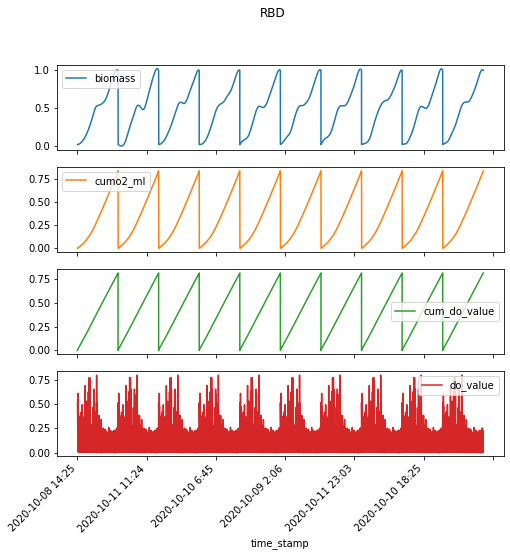

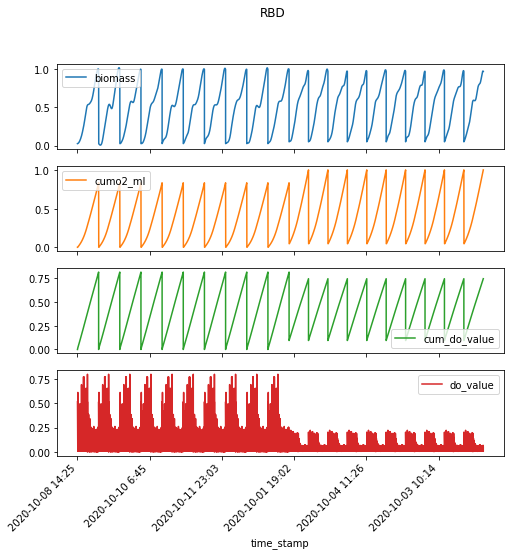

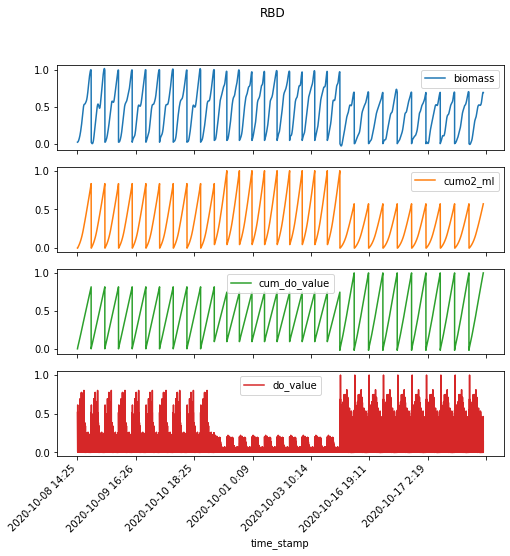

In [352]:

import numpy as np
import pandas as pd

all_dt=[]
df0=read_csv('dt_0_RBD_Normalized_from_biomass_5_values_selected.csv', header=0, index_col=0)
for i in range(1,10):
    all_dt.append(read_csv('dt_'+str(i)+'_RBD_Normalized_from_biomass_5_values_selected.csv', header=0, index_col=0))

all_datasets=df0.append(all_dt)
all_datasets.to_csv(r'all_dt_RBD_Normalized_from_biomass_5_values_selected.csv', index = True, header=True)

all_datasets.plot(subplots=True,style='-',figsize=(8,8), title="RBD")
plt.xticks(rotation=45)


all_dt=[]
for i in range(0,10):
    all_dt.append(read_csv('dt_'+str(i)+'_RBD_CD4L_Normalized_from_biomass_5_values_selected.csv', header=0, index_col=0))

all_datasets2=all_datasets.append(all_dt)
# all_datasets2.to_csv(r'all_dt_RBD_CD4L_Normalized_from_biomass_5_values_selected.csv', index = True, header=True)
all_datasets2.plot(subplots=True,style='-',figsize=(8,8), title="RBD")
plt.xticks(rotation=45)


all_dt=[]
for i in range(0,10):
    all_dt.append(read_csv('dt_'+str(i)+'_hSPB_Normalized_from_biomass_5_values_selected.csv', header=0, index_col=0))

all_datasets3=all_datasets2.append(all_dt)
all_datasets3.to_csv(r'all_dt_RBD_RBDCD4L_hSPB_Normalized_from_biomass_5_values_selected.csv', index = True, header=True)

all_datasets3.plot(subplots=True,style='-',figsize=(8,8), title="RBD")
plt.xticks(rotation=45)




/usr/local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<class 'pandas.core.frame.DataFrame'>
Index: 173810 entries, 2020-10-08 14:25 to 2020-10-20 19:55
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   biomass       173810 non-null  float64
 1   cumo2_ml      173810 non-null  float64
 2   cum_do_value  173810 non-null  float64
 3   do_value      173810 non-null  float64
dtypes: float64(4)
memory usage: 6.6+ MB
None


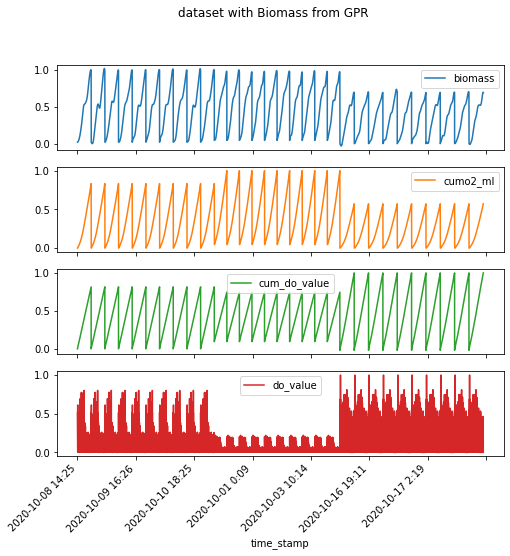

In [353]:
dt=read_csv('all_dt_RBD_RBDCD4L_hSPB_Normalized_from_biomass_5_values_selected.csv', header=0, index_col=0)
dt.plot(subplots=True,style='-',figsize=(8,8), title="dataset with Biomass from GPR")
plt.xticks(rotation=45)

print(dt.info())

/usr/local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


(array([-2000.,     0.,  2000.,  4000.,  6000.,  8000., 10000., 12000.,
        14000.]),
 [Text(-2000.0, 0, '2020-10-19 10:38'),
  Text(0.0, 0, '2020-09-30 19:43'),
  Text(2000.0, 0, '2020-10-02 5:02'),
  Text(4000.0, 0, '2020-10-03 14:20'),
  Text(6000.0, 0, '2020-10-16 23:59'),
  Text(8000.0, 0, '2020-10-18 9:18'),
  Text(10000.0, 0, '2020-10-19 18:37'),
  Text(12000.0, 0, ''),
  Text(14000.0, 0, '')])

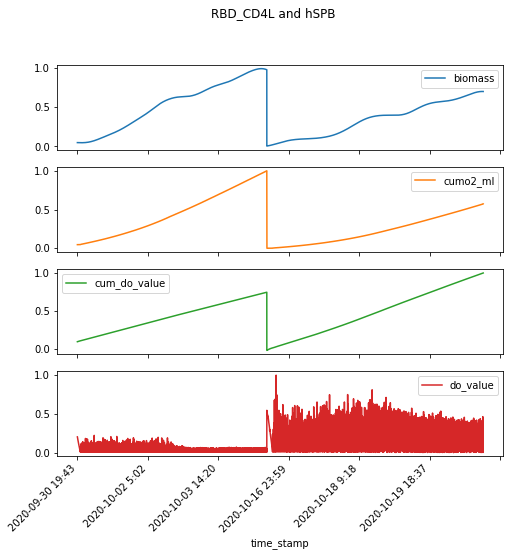

In [1049]:
df0=read_csv('trained_model_pairs_RBD_CD4L_hSPB/pair_59_dt_RBDCD4L_hSPB_Normalized_from_biomass_5_values_selected.csv', header=0, index_col=0)
df0.plot(subplots=True,style='-',figsize=(8,8), title="RBD_CD4L and hSPB")
plt.xticks(rotation=45)

# create the matrix of the datasets

In [1137]:
import numpy as np
import pandas as pd

idx=0
for i in range(20):
    df0=read_csv('dt_'+str(i)+'_RBD_CD4L_Normalized_from_biomass_5_values_selected.csv', header=0, index_col=0)
    for j in range(20):  
        df1=read_csv('dt_'+str(j)+'_hSPB_Normalized_from_biomass_5_values_selected.csv', header=0, index_col=0)
        dt_pairs=df0.append(df1)
        dt_pairs.to_csv(r'trained_models_from_matrix_50x50_RBDCD4L_hSPB/pair_'+str(idx)+'_dt_RBDCD4L_hSPB_Normalized_from_biomass_5_values_selected.csv', index = True, header=True)
        idx=1+idx
        print(idx)


# all_dt=[]
# df0=read_csv('trained_model_RBD_CD4L_hSPB/dt_0_RBD_CD4L_Normalized_from_biomass_5_values_selected.csv', header=0, index_col=0)
# for i in range(1,10):
#     all_dt.append(read_csv('dt_'+str(i)+'_RBD_CD4L_Normalized_from_biomass_5_values_selected.csv', header=0, index_col=0))
# all_datasets=df0.append(all_dt)
# all_datasets.plot(subplots=True,style='-',figsize=(8,8), title="RBD_CD4L")
# plt.xticks(rotation=45)


# all_dt=[]
# for i in range(0,10):
#     all_dt.append(read_csv('dt_'+str(i)+'_hSPB_Normalized_from_biomass_5_values_selected.csv', header=0, index_col=0))
# all_datasets2=all_datasets.append(all_dt)

# all_datasets2.to_csv(r'all_dt_RBDCD4L_hSPB_Normalized_from_biomass_5_values_selected.csv', index = True, header=True)

# dt=read_csv('all_dt_RBDCD4L_hSPB_Normalized_from_biomass_5_values_selected.csv', header=0, index_col=0)
# dt.plot(subplots=True,style='-',figsize=(8,8), title="RBD_CD4L and hSPB")
# plt.xticks(rotation=45)

# print(dt.info())

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


### generate one dataset with all samples from the runs CD4L and hSPB.

/usr/local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
/usr/local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<class 'pandas.core.frame.DataFrame'>
Index: 115210 entries, 2020-09-30 19:43 to 2020-10-20 19:55
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   biomass       115210 non-null  float64
 1   cumo2_ml      115210 non-null  float64
 2   cum_do_value  115210 non-null  float64
 3   do_value      115210 non-null  float64
dtypes: float64(4)
memory usage: 4.4+ MB
None


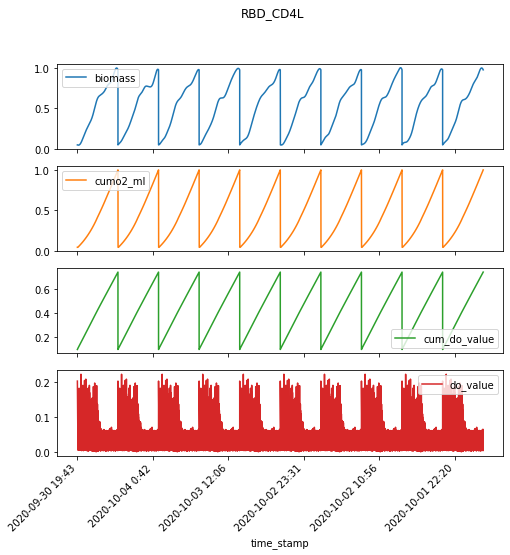

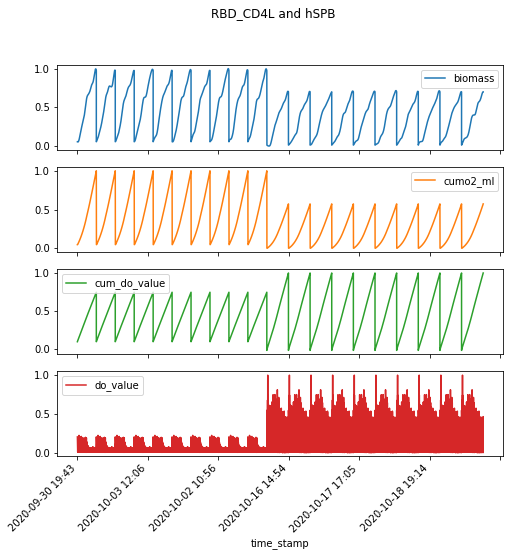

In [977]:
import numpy as np
import pandas as pd

all_dt=[]
df0=read_csv('dt_0_RBD_CD4L_Normalized_from_biomass_5_values_selected.csv', header=0, index_col=0)
for i in range(1,10):
    all_dt.append(read_csv('dt_'+str(i)+'_RBD_CD4L_Normalized_from_biomass_5_values_selected.csv', header=0, index_col=0))
all_datasets=df0.append(all_dt)
all_datasets.plot(subplots=True,style='-',figsize=(8,8), title="RBD_CD4L")
plt.xticks(rotation=45)


all_dt=[]
for i in range(0,10):
    all_dt.append(read_csv('dt_'+str(i)+'_hSPB_Normalized_from_biomass_5_values_selected.csv', header=0, index_col=0))
all_datasets2=all_datasets.append(all_dt)

all_datasets2.to_csv(r'all_dt_RBDCD4L_hSPB_Normalized_from_biomass_5_values_selected.csv', index = True, header=True)

dt=read_csv('all_dt_RBDCD4L_hSPB_Normalized_from_biomass_5_values_selected.csv', header=0, index_col=0)
dt.plot(subplots=True,style='-',figsize=(8,8), title="RBD_CD4L and hSPB")
plt.xticks(rotation=45)

print(dt.info())

# Dataset for data augementation experiment



In [ ]:
df0=read_csv('dataset_RBD_CD4L_Normalized.csv', header=0, index_col=0)
df1=read_csv('dataset_hSPB_Normalized.csv', header=0, index_col=0)

# trained_models_data_aug

In [1264]:
df_RBD_CD4L=read_csv('dataset_RBD_CD4L_Normalized.csv', header=0, index_col=0)
df_hSPB=read_csv('dataset_hSPB_Normalized.csv', header=0, index_col=0)
idx=0
for i in range(10):
    df0=read_csv('dt_'+str(i)+'_RBD_CD4L_Normalized_from_biomass_5_values_selected.csv', header=0, index_col=0)
    dt_pairs=df_hSPB.append(df0)
    dt_pairs.to_csv(r'trained_models_data_aug/pair_'+str(idx)+'_dt_RBDCD4L_hSPB_Normalized_from_biomass_5_values_selected.csv', index = True, header=True)    
    idx=1+idx
for i in range(10,20):
    df1=read_csv('dt_'+str(i)+'_hSPB_Normalized_from_biomass_5_values_selected.csv', header=0, index_col=0)
    dt_pairs=df_RBD_CD4L.append(df1)
    dt_pairs.to_csv(r'trained_models_data_aug/pair_'+str(idx)+'_dt_RBDCD4L_hSPB_Normalized_from_biomass_5_values_selected.csv', index = True, header=True)    
    idx=1+idx

/usr/local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
/usr/local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
/usr/local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<class 'pandas.core.frame.DataFrame'>
Index: 6143 entries, 2020-10-16 13:38 to 2020-10-20 19:55
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   biomass       6143 non-null   float64
 1   cumo2_ml      6143 non-null   float64
 2   cum_do_value  6143 non-null   float64
 3   do_value      6143 non-null   float64
dtypes: float64(4)
memory usage: 240.0+ KB
None


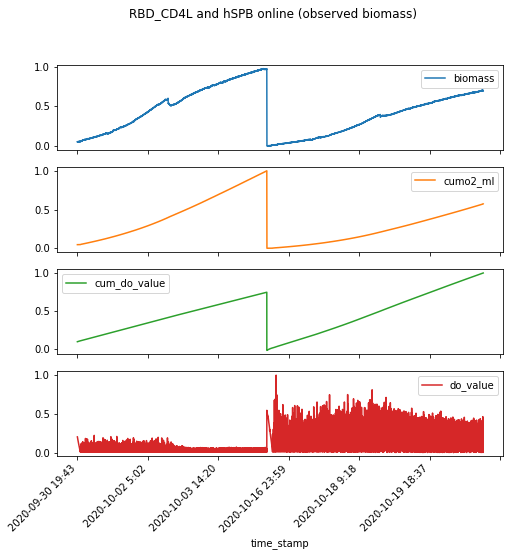

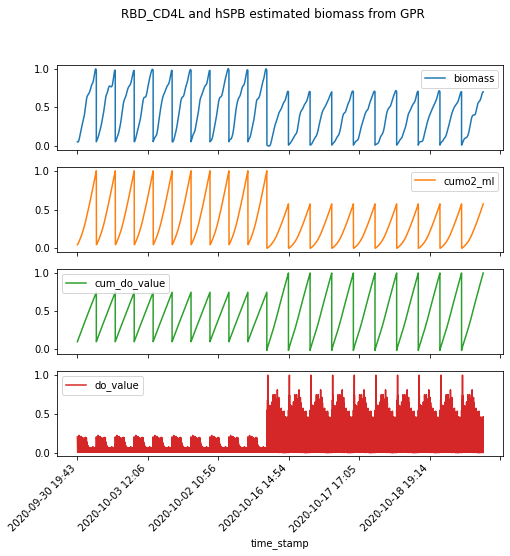

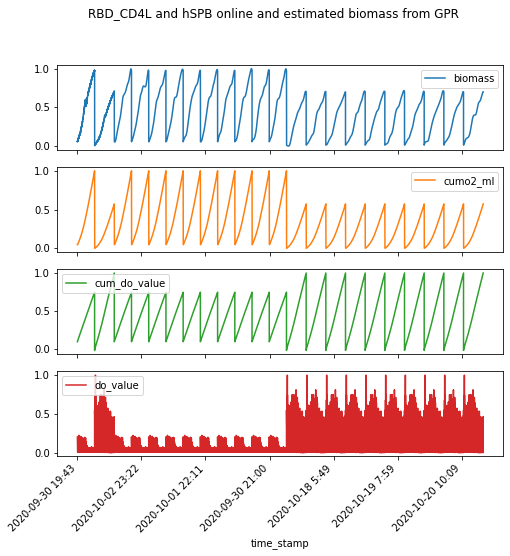

In [575]:
dt0=read_csv('all_dt_RBDCD4L_hSPB_Normalized.csv', header=0, index_col=0)
dt0.plot(subplots=True,style='-',figsize=(8,8), title="RBD_CD4L and hSPB online (observed biomass)")
plt.xticks(rotation=45)

dt1=read_csv('all_dt_RBDCD4L_hSPB_Normalized_from_biomass_5_values_selected.csv', header=0, index_col=0)
dt1.plot(subplots=True,style='-',figsize=(8,8), title="RBD_CD4L and hSPB estimated biomass from GPR")
plt.xticks(rotation=45)

all_datasets=dt0.append(dt1)
all_datasets.plot(subplots=True,style='-',figsize=(8,8), title="RBD_CD4L and hSPB online and estimated biomass from GPR")
plt.xticks(rotation=45)
all_datasets.to_csv(r'all_dt_RBDCD4L_hSPB_Normalized_with_biomass_online_and_estimated_from_GPR.csv', index = True, header=True)


print(dt.info())

# Script template to run in server



In [ ]:
# multivariate multi-step encoder-decoder lstm
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
import tensorflow as tf
from numpy import concatenate
import numpy as np
from matplotlib import pyplot
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt



# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
	# flatten data
	#data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	data=train
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end <= len(data):
			X.append(data[in_start:in_end, 1:]) #X (input) does not have biomass
			y.append(data[in_end:out_end, 0])  #Y (output) will have only biomass
		# move along one time step
		in_start += 1
	return array(X), array(y)

n_past = 60    # no of past observations
n_future = 60  # no of future observations 
dt_RBD_N = read_csv('dataset_RBD_Normalized.csv', header=0, index_col=0)
train = dt_RBD_N
scalers={}

train_x, train_y = to_supervised(train.values, n_past, n_future)
print(train_x.shape,train_y.shape)

# train the model
# define parameters
verbose, epochs, batch_size = 1, 50, 32
n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
# reshape output into [samples, timesteps, features]
train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))

# define model
encoder_inputs = tf.keras.layers.Input(shape=(n_timesteps, n_features))
encoder_l1 = tf.keras.layers.LSTM(150,return_sequences = True, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
encoder_l2 = tf.keras.layers.LSTM(150, return_state=True)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]
#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])
#
decoder_l1 = tf.keras.layers.LSTM(150, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_l2 = tf.keras.layers.LSTM(150, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1))(decoder_l2)
#
model = tf.keras.models.Model(encoder_inputs,decoder_outputs2)

model.summary()

# fit network
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history=model.fit(train_x,train_y,epochs=epochs,batch_size=batch_size,verbose=verbose,callbacks=[reduce_lr])

model.save('ED_LSTM_1h_ahead_RBD_N_3f.h5')


# predict function

In [35]:
def forecast_of_dataset_by_windons(data,windons,model):
    test = data
    scalers={}
    
    for i in data.columns:
        scaler = MinMaxScaler(feature_range=(-1,1))
        s_s = scaler.fit_transform(test[i].values.reshape(-1,1))
        s_s=np.reshape(s_s,len(s_s))
        scalers['scaler_'+ i] = scaler
        test[i]=s_s
    
    test_input=test[['cumo2_ml', 'ph_value', 'agitation_speed_rpm','temp_probe_celcius', 'q_co2_overlay_ml_min']]
    test_output=test[['biomass']]
    
    size=len(test_input)-len(test_input)%windons
    data_test = array(split(test_input[:size], int(size/windons)))
    pred=model.predict(data_test)
    pred[:,:,0]=scalers['scaler_biomass'].inverse_transform(pred[:,:,0])
    preddata = pred.reshape((pred.shape[0]*pred.shape[1], pred.shape[2]))          
    
    size=len(test_output)-len(test_output)%windons
    output = array(split(test_output[:size], int(size/windons)))
    output[:,:,0]=scalers['scaler_biomass'].inverse_transform(output[:,:,0])
    output_test = output.reshape((output.shape[0]*output.shape[1], output.shape[2]))      
    
    return preddata,output_test

                     
                      
                      

In [817]:
def forecast_of_dataset_by_windons_N(data_N,windons,model):
    test = data_N

    test_input=test[['cumo2_ml','cum_do_value','do_value']]#,'agitation_speed_rpm']]
    
    size=len(test_input)-len(test_input)%windons
    data_test = array(split(test_input[:size], int(size/windons)))
    pred=model.predict(data_test)
    preddata = pred.reshape((pred.shape[0]*pred.shape[1], pred.shape[2]))          
    preddata=inverse(preddata,249168.775,2248504.329)
    
    return preddata

def forecast_of_dataset_NRC_by_windons_N(data_N,windons,model):
    test = data_N

    test_input=test[['cumo2_ml','cum_do_value','do_value']]#,'agitation_speed_rpm']]
    
    size=len(test_input)-len(test_input)%windons
    data_test = array(split(test_input[:size], int(size/windons)))
    pred=model.predict(data_test)
    preddata = pred.reshape((pred.shape[0]*pred.shape[1], pred.shape[2]))          
    preddata=inverse(preddata,411317.4314228384, 3374518.522399086)
    
    return preddata


# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
	# flatten data
	#data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	data=train
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end <= len(data):
			X.append(data[in_start:in_end, 1:]) #X (input) does not have biomass
			y.append(data[in_end:out_end, 0])  #Y (output) will have only biomass
		# move along one time step
		in_start += 1
	return array(X), array(y)
                      

# PREDICTION TESTS

## test with the model_all_dt_RBDCD4L_hSPB_Normalized_observed_data

In [437]:
## test with the model_all_dt_RBDCD4L_hSPB_Normalized_observed_data

model_all_dt_RBDCD4L_hSPB_Normalized = tf.keras.models.load_model('model_all_dt_RBDCD4L_hSPB_Normalized.h5')
# Show the model architecture
model_all_dt_RBDCD4L_hSPB_Normalized.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60, 3)]      0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 60, 150), (N 92400       input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 150), (None, 180600      lstm[0][0]                       
__________________________________________________________________________________________________
repeat_vector (RepeatVector)    (None, 60, 150)      0           lstm_1[0][0]                     
______________________________________________________________________________________________

(5820, 1) (5860, 1)


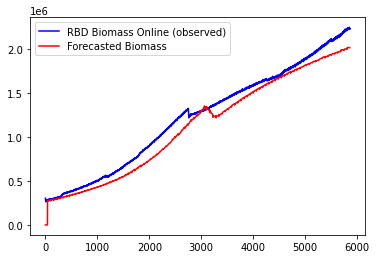

RMSE: 115170.52676870416


In [474]:
pred=forecast_of_dataset_by_windons_N(dt_RBD_N,60,model_all_dt_RBDCD4L_hSPB_Normalized)
obsdata=dt_RBD[['biomass']].values
print(pred.shape,obsdata.shape)

pyplot.plot(obsdata, 'b-', label='RBD Biomass Online (observed)')
pyplot.plot(np.insert(pred.reshape(5820), 0,[0]*40)   , 'r-', label='Forecasted Biomass')
# plt.scatter(idxtime,Total_Cell_Density,c='g',label='RBD Total_Cell_Density Offline')
# plt.scatter(idxtime,Viable_Cell_Density,c='grey',label='RBD Viable_Cell_Density Offline')
pyplot.legend()
pyplot.show()

print('RMSE:',sqrt(mean_squared_error(obsdata.reshape(5860),np.insert(pred.reshape(5820), 0,[0]*40))))

(5340, 1) (5378, 1)


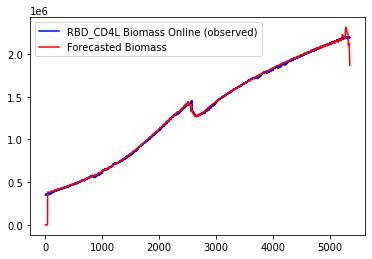

RMSE: 35698.233730000975


In [503]:
pred=forecast_of_dataset_by_windons_N(dt_RBD_CD4L_N,60,model_all_dt_RBDCD4L_hSPB_Normalized)
obsdata=dt_RBD_CD4L[['biomass']].values
print(pred.shape,obsdata.shape)

# pred,obsdata=forecast_of_dataset_by_windons(dt_RBD_CD4L,60,model)

pyplot.plot(obsdata[:-30], 'b-', label='RBD_CD4L Biomass Online (observed)')
pyplot.plot(np.insert(pred.reshape(5340), 0,[0]*38)[:-30] , 'r-', label='Forecasted Biomass')
# pyplot.plot(pred , 'r-', label='Biomass Forecasted')
pyplot.legend()
pyplot.show()

print('RMSE:',sqrt(mean_squared_error(obsdata.reshape(5378)[:-30],np.insert(pred.reshape(5340), 0,[0]*38)[:-30])))

(6120, 1) (6143, 1)


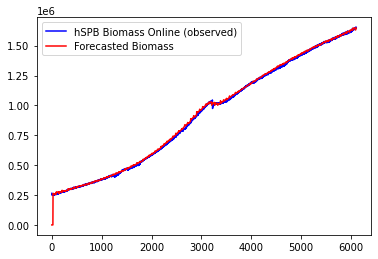

RMSE: 18499.992209822398


In [496]:
pred=forecast_of_dataset_by_windons_N(dt_hSPB_N,60,model_all_dt_RBDCD4L_hSPB_Normalized)
obsdata=dt_hSPB[['biomass']].values
print(pred.shape,obsdata.shape)

# pred,obsdata=forecast_of_dataset_by_windons(dt_RBD_CD4L,60,model)

pyplot.plot(obsdata[:-40], 'b-', label='hSPB Biomass Online (observed)')
pyplot.plot(np.insert(pred.reshape(6120)[:-40], 0,[0]*23) , 'r-', label='Forecasted Biomass')
# pyplot.plot(pred , 'r-', label='Biomass Forecasted')
pyplot.legend()
pyplot.show()

print('RMSE:',sqrt(mean_squared_error(obsdata.reshape(6143)[:-40],np.insert(pred.reshape(6120), 0,[0]*23)[:-40])))

## test with the
## model_all_dt_RBDCD4L_hSPB_Normalized_from_biomass_5_values_selected from GPR

In [430]:
model_all_dt_RBDCD4L_hSPB_Normalized_from_biomass_5_values_selected = tf.keras.models.load_model('model_all_dt_RBDCD4L_hSPB_Normalized_from_biomass_5_values_selected.h5')
# Show the model architecture
model_all_dt_RBDCD4L_hSPB_Normalized_from_biomass_5_values_selected.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60, 3)]      0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 60, 150), (N 92400       input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 150), (None, 180600      lstm[0][0]                       
__________________________________________________________________________________________________
repeat_vector (RepeatVector)    (None, 60, 150)      0           lstm_1[0][0]                     
______________________________________________________________________________________________

(5820, 1) (5860, 1)


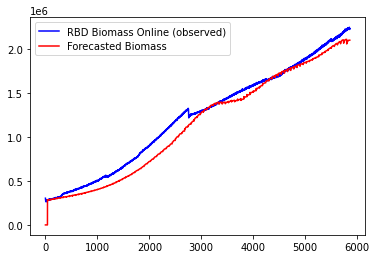

RMSE: 108130.48004880888


In [485]:
pred=forecast_of_dataset_by_windons_N(dt_RBD_N,60,model_all_dt_RBDCD4L_hSPB_Normalized_from_biomass_5_values_selected)
obsdata=dt_RBD[['biomass']].values
print(pred.shape,obsdata.shape)

pyplot.plot(obsdata, 'b-', label='RBD Biomass Online (observed)')
pyplot.plot(np.insert(pred.reshape(5820), 0,[0]*40) , 'r-', label='Forecasted Biomass')
# plt.scatter(idxtime,Total_Cell_Density,c='g',label='RBD Total_Cell_Density Offline')
# plt.scatter(idxtime,Viable_Cell_Density,c='grey',label='RBD Viable_Cell_Density Offline')
pyplot.legend()
pyplot.show()

print('RMSE:',sqrt(mean_squared_error(obsdata.reshape(5860),np.insert(pred.reshape(5820), 0,[0]*40))))

(5340, 1) (5378, 1)


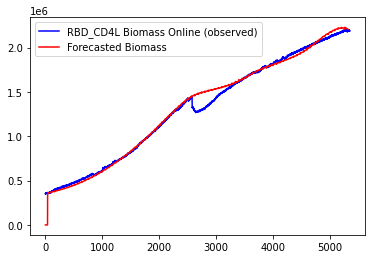

RMSE: 62028.73105341629


In [502]:
pred=forecast_of_dataset_by_windons_N(dt_RBD_CD4L_N,60,model_all_dt_RBDCD4L_hSPB_Normalized_from_biomass_5_values_selected)
obsdata=dt_RBD_CD4L[['biomass']].values
print(pred.shape,obsdata.shape)

# pred,obsdata=forecast_of_dataset_by_windons(dt_RBD_CD4L,60,model)

pyplot.plot(obsdata[:-30], 'b-', label='RBD_CD4L Biomass Online (observed)')
pyplot.plot(np.insert(pred.reshape(5340)[:-30], 0,[0]*38)[:-30] , 'r-', label='Forecasted Biomass')
# pyplot.plot(pred , 'r-', label='Biomass Forecasted')
pyplot.legend()
pyplot.show()

print('RMSE:',sqrt(mean_squared_error(obsdata.reshape(5378)[:-30],np.insert(pred.reshape(5340), 0,[0]*38)[:-30])))

(6120, 1) (6143, 1)


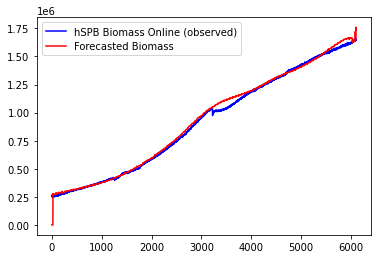

RMSE: 30588.921422019353


In [494]:
pred=forecast_of_dataset_by_windons_N(dt_hSPB_N,60,model_all_dt_RBDCD4L_hSPB_Normalized_from_biomass_5_values_selected)
obsdata=dt_hSPB[['biomass']].values
print(pred.shape,obsdata.shape)

# pred,obsdata=forecast_of_dataset_by_windons(dt_RBD_CD4L,60,model)

pyplot.plot(obsdata[:-40], 'b-', label='hSPB Biomass Online (observed)')
pyplot.plot(np.insert(pred.reshape(6120), 0,[0]*23)[:-40], 'r-', label='Forecasted Biomass')
# pyplot.plot(pred , 'r-', label='Biomass Forecasted')
pyplot.legend()
pyplot.show()
print('RMSE:',sqrt(mean_squared_error(obsdata.reshape(6143)[:-40],np.insert(pred.reshape(6120), 0,[0]*23)[:-40])))